本文档主要分为两部分：
1. 第一部分关于对宽场荧光显微镜的成像过程进行建模，最终会在指定目录`../source/ours`下保存一个卷积结果`measurement-<file_name>.tif`和一个参数文件`parameters-<file_name>.mat`
2. 第二部分关于对宽场荧光系统的 PSF 建模，会利用两种方法对 PSF 进行计算。主要学习第一种方法中，如何将公式转化为代码的形式。如果有困难可以参考`../misc/psf_torch.py`

**注**：本文档中给出的参考书籍与文献的阅读均不做要求，仅作参考用

In [3]:
import sys
sys.path.append('../misc/')

import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.io import savemat, loadmat

import torch
import torch.nn.functional as F
import torch.nn as nn

from psf_torch import PsfGenerator3D
from utils import *

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.cuda.FloatTensor

## 宽场荧光显微镜成像过程的建模

宽场荧光显微镜成像的基本原理可以参考[一文读懂宽场与共聚焦显微成像基本原理](https://zhuanlan.zhihu.com/p/702798050)。

将待观测样本中荧光分子的强度分布看作系统的输入，实际的测量结果（也就是实际求解时作为 CoCoA 系统的输入的那个三维图像堆栈）看作系统的输出，那么这个光学系统可以看作一个***线性空间不变系统***。
因此其成像过程可以建模为样本的荧光分子强度分布$o(\boldsymbol r)$与光学系统的点扩散函数$p(\boldsymbol r)$（可以类比于信号与系统中的冲激响应，参考[点扩散函数](https://zhuanlan.zhihu.com/p/904954484)）在空间上的卷积

$$
m(\boldsymbol r) = \int o(\boldsymbol r^\prime) \cdot p(\boldsymbol r - \boldsymbol r^\prime) \mathrm d\boldsymbol r^\prime
$$


在这里，我们通过将宽场荧光显微镜沿光轴方向扫描，以得到三维的图像堆栈。
因此需要将样本分布$o(\boldsymbol r)$与点扩散函数$p(\boldsymbol r)$建模为三维空间中的信号分布，$\boldsymbol r = (x, y, z)^T$

**注意**，由于计算机只能进行离散运算，我们在模拟成像过程时，所有的三维结构实际上都是用一个尺寸为`[D, H, W]`的三维矩阵来进行表示的（三维数据的体素表示）。每一个体素（三维矩阵的元素）代表在三维空间中的采样点，而相邻体素之间的间隔就是实际系统的空间采样间隔（也即后面的体素大小）



### 读取样本数据

让我们从[box链接](https://box.nju.edu.cn/d/7b5fa520a6d74f35af58/)中下载所需的样本数据，放在`source/ours`目录下。编写代码读取相应的数据并展示

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

Data shape: (50, 500, 500)


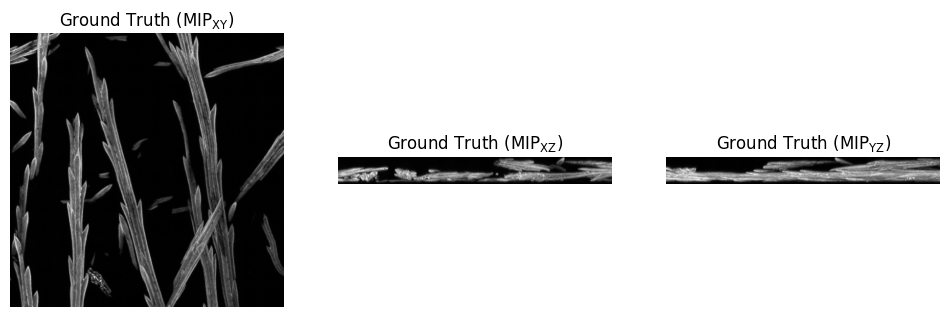

In [4]:
file_directory = "../source/ours/" # TODO: 替换为你的文件路径
file_name = "LSFM3.tif" # TODO: 替换为你的文件路径
data = tiff.imread(os.path.join(file_directory, file_name)).astype(np.float32)
data = data / data.max() # 归一化
data_shape = data.shape

print("Data shape:", data_shape)
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1); plt.imshow(data.max(0), cmap='gray'); plt.axis('off'); plt.title('Ground Truth (MIP$_{XY}$)')
plt.subplot(1, 3, 2); plt.imshow(data.max(1), cmap='gray'); plt.axis('off'); plt.title('Ground Truth (MIP$_{XZ}$)')
plt.subplot(1, 3, 3); plt.imshow(data.max(2), cmap='gray'); plt.axis('off'); plt.title('Ground Truth (MIP$_{YZ}$)')
plt.show()

可以看到这是一个清晰的样本数据。在这里我们将其作为样本的真实结构$o(\boldsymbol r)$进行仿真


### 计算系统PSF

对于系统的PSF，我们可以根据 CoCoA 给出的代码[psf_torch.py](../misc/psf_torch.py)进行计算。

让我们采用以下参数进行仿真（生成PSF所需的物理参数）：
| z方向体素大小($\mu\mathrm m$) | y方向体素大小($\mu\mathrm m$) | x方向体素大小($\mu\mathrm m$) | 荧光波长$\lambda$($\mu\mathrm m$) | 浸没介质折射率$n_i$ | 物镜数值孔径$\mathrm{NA}$ |
|---------|-------------------|-------------------|---------------------------|--|--|
| 0.2 | 0.086 | 0.086 | 0.488 | 1.33 | 1.2 |

In [5]:
voxel_unit = (0.5, 0.1, 0.1) # TODO: 替换为你的体素尺寸
wave_length = 0.515 # TODO: 替换为你的波长
n = 1.33 # TODO: 替换为你的折射率
NA = 1.1 # TODO: 替换为你的数值孔径
wavefront = np.array([0]) # TODO: 像差项，可以设置为0或其他值
psf_shape = data_shape

psf_generator = PsfGenerator3D(
    psf_shape=psf_shape,
    units=voxel_unit,
    lam_detection=wave_length,
    n=n,
    na_detection=NA,
)

psf = psf_generator.incoherent_psf(
    nn.parameter.Parameter(torch.from_numpy(wavefront).float()), # 像差项
    normalized=True,
) # 将 Zernike 多项式的系数设置为0


取$\sqrt[3]{p(\boldsymbol r)}$增强对比度，用于可视化

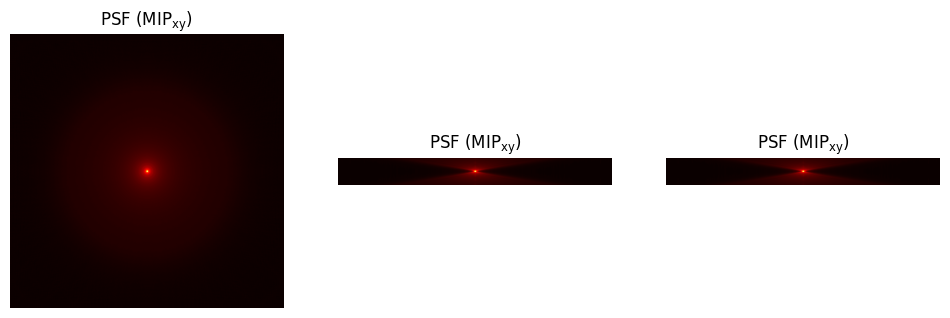

In [6]:
psf_ = psf.detach().cpu().numpy()
plt.figure(figsize = (12, 8))
# 显示PSF的最大值投影，cmap是伪彩
plt.subplot(1,3,1); plt.imshow(np.cbrt(psf_).max(0), cmap = 'hot'); plt.title('PSF (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.cbrt(psf_).max(1), cmap = 'hot'); plt.title('PSF (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(np.cbrt(psf_).max(2), cmap = 'hot'); plt.title('PSF (MIP$_{xy}$)'); plt.axis('off')
plt.show()

将PSF的归一化，确保卷积过程中能量一致

In [7]:
psf = psf / psf.sum()

思考一个问题：
- 为什么对PSF归一化时要保证PSF的总强度为1？
- 如果不把PSF的总强度归一化到1，而是把PSF每一层的总强度归一化到1可不可以？
- **可以从PSF的物理含义去思考**

### 计算三维卷积，仿真成像过程

对离散化的$o(\boldsymbol r), p(\boldsymbol r)$进行卷积
$$
m(\boldsymbol r) = \sum_{\boldsymbol r^\prime} o(\boldsymbol r^\prime) \cdot p(\boldsymbol r - \boldsymbol r^\prime)
$$

请你实现下面的`convolve_3d`函数，用于计算$o(\boldsymbol r)$和$p(\boldsymbol r)$的三维卷积。
你可以利用`pytorch`内置的三维卷积函数`torch.conv3d`进行运算（参考[官方文档](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv3d.html#torch.nn.functional.conv3d)）。

也可以利用傅里叶变换的卷积定理来计算点乘，即
$$
m(\boldsymbol r) = \mathcal F^{-1}\left\{O(\boldsymbol \omega) \cdot P(\boldsymbol \omega)\right\}
$$
其中$O$和$P$分别是对$o$和$p$的三维傅里叶变换

In [16]:
def convolve_3d(data, psf):
    data = fftshift(fftn(ifftshift(data)))
    psf = fftshift(fftn(ifftshift(psf)))
    # _im = apply_window(_im1) * apply_window(_im2)
    _im = data * psf
    # _im = torch.einsum('ijk,ijk->ijk', _im1, _im2)
    
    return torch.real(fftshift(ifftn(ifftshift(_im))))

data = data.to(DEVICE)
psf = psf.to(DEVICE)
# TODO: 三维卷积
measurement_conv = convolve_3d(data, psf)
print(f"仿真测量数据的尺寸: {measurement_conv.shape}")
print(f"样本真实分布GT的总能量：{data.sum()}")
print(f"仿真测量数据的总能量：{measurement_conv.sum()}")

measurement_conv = measurement_conv / measurement_conv.max() # 归一化

仿真测量数据的尺寸: torch.Size([50, 500, 500])
样本真实分布GT的总能量：175752.875
仿真测量数据的总能量：175752.890625


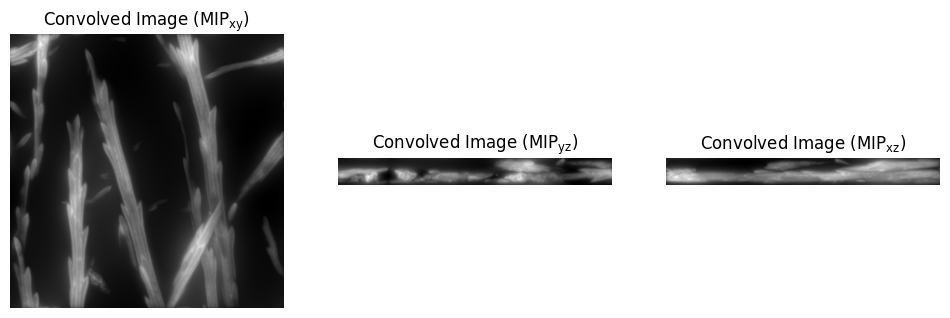

In [17]:
measurement_conv_np = measurement_conv.detach().cpu().numpy()
plt.figure(figsize = (12, 8))
# 显示卷积结果的最大值投影
plt.subplot(1,3,1); plt.imshow(measurement_conv_np.max(0), cmap = 'gray'); plt.title('Convolved Image (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(measurement_conv_np.max(1), cmap = 'gray'); plt.title('Convolved Image (MIP$_{yz}$)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(measurement_conv_np.max(2), cmap = 'gray'); plt.title('Convolved Image (MIP$_{xz}$)'); plt.axis('off')
plt.show()

### 保存模拟的测量结果(Convolved Image)以及系统参数

In [18]:
measurement_save = measurement_conv_np * 65535
tiff.imwrite(os.path.join(file_directory, "measurement-"+file_name), measurement_save.astype(np.uint16))
savemat(os.path.join(file_directory, "parameters-"+file_name.split(".")[0]+".mat"), {
    "psf_shape": psf_.shape,
    "voxel_unit": voxel_unit,
    "wave_length": wave_length,
    "n": n,
    "NA": NA,
    "wf": wavefront,
})

到此为止，你已经完成了对宽场荧光显微镜的成像过程的基本仿真（有时为了模拟实际成像条件，我们还会向仿真的测量结果`measurement_conv`中添加适当的高斯/泊松噪声）

恭喜！

## 宽场荧光显微镜的PSF模型

在上一节中，我们将CoCoA论文代码中给出的PSF模型作为黑盒使用，直接根据系统参数生成了相应的三维PSF。

CoCoA 中的 PSF 模型是利用标量衍射理论中的角谱传播，先计算出相干光源的 PSF ，在取其强度值得到非相干光的 PSF 。现在让我们尝试从角谱传播的理论出发，自己编写代码计算一下系统的三维PSF，然后与 CoCoA 中的 PSF 模型计算误差。

### 1. 基于角谱传播的PSF模型

让我们首先考虑一个三维空间中的点光源$\delta(\boldsymbol r)$经过一个数值孔径为$\mathrm{NA}$的宽场荧光系统的情况，此时我们可以用标量衍射理论中的角谱传播理论对点光源的传播情况进行计算，具体的光学理论可以参考 Goodman 的[傅里叶光学导论](https://box.nju.edu.cn/f/288c891afdc54692840d/?dl=1)的第三章内容（3.10小节 平面波的角谱）。

假设一个波长为$\lambda$的电磁波入射到横向的$(x,y)$平面上,这个波有一个沿正$z$方向传播的分量。记$z=0$平面上的复场为$U(x,y,0)$，我们希望计算由它引起的在$z=z_0$的平面处的复光场$U(x,y,z_0)$。为此，我们利用角谱传播构造它们的角谱之间的关系式。

**注**：平面波的角谱可以理解为在某一个平面上的复光场的二维傅里叶变换的结果

根据《傅里叶光学导论》3.10小节中给出的解形式，复光场$U(x,y,z_0)$的角谱（记作$A(f_X, f_Y; z_0)$）可以写成
$$
A(f_X, f_Y; z_0) = A(f_X, f_Y; 0) \cdot e^{j\frac{2\pi}{\lambda_0}z_0\sqrt{1-(f_X^2+f_Y^2)\lambda_0^2}}
$$

为了计算角谱传播，我们首先需要构造出一个用于计算角谱的三维矩阵，其第一个维度代表$z$轴上的坐标，另外两个维度代表$(f_X, f_Y)$角谱空间中的坐标

In [19]:
Nz, Ny, Nx = psf_shape
dz, dy, dx = voxel_unit

# 创建坐标轴
kx = torch.fft.fftfreq(Nx, dx).type(dtype).to(DEVICE)
ky = torch.fft.fftfreq(Ny, dy).type(dtype).to(DEVICE)
z = dz * (torch.arange(Nz) - Nz // 2)
z = z.type(dtype).to(DEVICE)

# 坐标
Z3, KY3, KX3 = torch.meshgrid(z, ky, kx, indexing="ij") # [z, ky, kx]
KR3 = torch.sqrt(KX3 ** 2 + KY3 ** 2)


接着我们需要利用物理参数和构造出来的三维坐标，计算上面角谱传播公式中的传递函数项

$$
H(f_X, f_Y; z) = e^{j\frac{2\pi}{\lambda_0}z \sqrt{1-(f_X^2+f_Y^2)\lambda_0^2}}
$$

其中的$\lambda_0 = \lambda / n$是光在介质中的实际波长

In [20]:

def get_transfer_function(Z3, KR3, wavelength):
    """
    计算角谱的传递函数
    即角谱传播公式右侧，原角谱点乘的那一项
    注意要排除根号下小于0的部分

    Args:
        KZ3 (torch.Tensor): Z轴坐标
        KR3 (torch.Tensor): 角谱平面 sqrt(fX^2 + fY^2)
        wavelength (float): 光波长
    """
    H = torch.sqrt(1. - KR3 ** 2 * wavelength ** 2).type(dtype).cuda(0)

    out_ind = torch.isnan(H)
    kprop = torch.exp(-2.j * np.pi * Z3 / wavelength * H)
    kprop[out_ind] = 0.
    return kprop
    
    
# 需要的是光在介质中的实际波长 wavelength/n
kprop = get_transfer_function(Z3, KR3, wave_length/n)

接下来我们需要计算光源的角谱。在这里就是$(0,0,0)$处点光源（即$\delta(\boldsymbol r)$）在$z=0$平面上激发的复光场的角谱，即$\mathcal F \{\delta(\boldsymbol r)\} = 1$。同时要考虑到宽场荧光显微镜在$(f_X, f_Y)$角谱平面的低通特性，截止频率为$f_c = \frac{\mathrm{NA}}{\lambda} = \frac{n\cdot \sin \theta}{\lambda}$。

让我们根据以上内容写出最终$z=z_0$平面处复光场的角谱

In [21]:
def cut_freq_mask(cut_freq, KR):
    """
    根据光学系统的低通特性，生成一个截止频率为`cut_freq`的 0 1 低通滤波器
    Args:
        cut_freq (float): 截止频率
        KR (torch.Tensor): 角谱平面 sqrt(fX^2 + fY^2)
    """
    kmask3 = (KR <= cut_freq)
    # TODO: 根据公式写出截止频率为 cut_freq 的低通滤波
    return kmask3

kcut = 1. * NA / wave_length
kmask = cut_freq_mask(kcut, KR3).type(dtype).to(DEVICE)


# 角谱传播
k = 1. * kmask * kprop
# 在角谱平面上计算反傅里叶变换
coherent_psf = torch.fft.ifftshift(torch.fft.ifftn(k, dim=(1, 2)), dim=(1, 2))

由于宽场荧光系统是非相干成像系统（可以理解为物体中的每一个荧光分子都是独立发光的，不存在时间相干性），因此要对反傅里叶变换的结果取模平方，计算非相干成像下的PSF

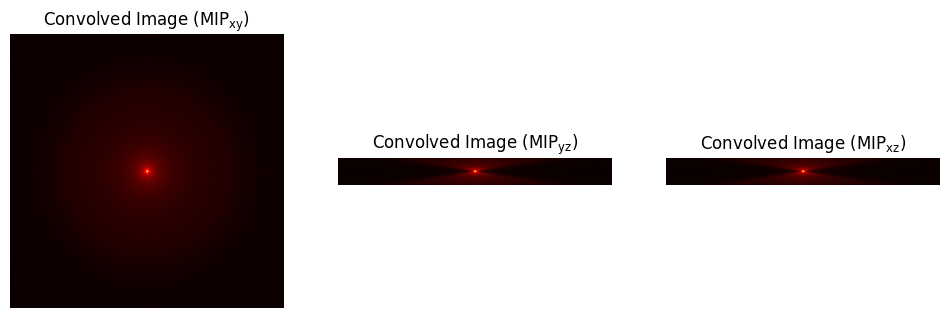

In [22]:
incoherent_psf = torch.abs(coherent_psf) ** 2
# 保证每一层的能量保持一致
incoherent_psf = incoherent_psf / torch.sum(incoherent_psf, dim=(1,2), keepdim=True)

incoherent_psf_np = incoherent_psf.detach().cpu().numpy()
plt.figure(figsize = (12, 8))
# 显示 PSF 的最大值投影
plt.subplot(1,3,1); plt.imshow(np.cbrt(incoherent_psf_np).max(0), cmap='hot'); plt.title('Convolved Image (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.cbrt(incoherent_psf_np).max(1), cmap='hot'); plt.title('Convolved Image (MIP$_{yz}$)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(np.cbrt(incoherent_psf_np).max(2), cmap='hot'); plt.title('Convolved Image (MIP$_{xz}$)'); plt.axis('off')
plt.show()

尝试计算我们生成的 PSF 与之前利用 CoCoA 中 PSF 模型计算结果之间的误差

In [38]:
def calculate_error(psf1, psf2):
    """
    计算两个 psf 之间的误差并返回
    首先需要对两个 psf 各自进行归一化
    """
    # 归一化到总能量为 1（也可以用最大值归一化）
    psf1_norm = psf1 / psf1.sum()
    psf2_norm = psf2 / psf2.sum()

    # 计算平均绝对误差
    error = torch.mean(torch.abs(psf1_norm - psf2_norm))
    # TODO: 计算两个 psf 之间的平均绝对值误差并返回，用 torch 包
    return error

error = calculate_error(incoherent_psf, psf)
print(f"PSF 误差: {error.item()}")


PSF 误差: 2.0652114729718257e-13


### 2. 基于 Gibson-Lanni 模型的 PSF 计算

[Gibson-Lanni 模型](https://opg.optica.org/josaa/fulltext.cfm?uri=josaa-9-1-154&id=4261)利用基尔霍夫衍射积分和成像系统中的光程差来准确计算宽场显微镜下的 PSF ，其准确的计算公式如下。

![Gibson-Lanni formulation](../pic/Gibson-Lanni.png)

由于公式中积分的存在，直接利用此公式计算系统 PSF 往往较慢。为此，[一种快速的计算方式](https://fxue-casc.github.io/josaa_2017_published.pdf)利用贝塞尔函数的性质来加速此模型的计算。

由于具体的计算较为复杂，我们在这里直接调用现成的 python 包来进行计算

In [31]:
! pip install MicroscPSF-Py

In [32]:
import microscPSF.microscPSF as msPSF

mp = msPSF.m_params
mp["NA"] = NA
# 这里假设样本的折射率与介质折射率一致
mp["ns"] = n
mp["ni"] = n
mp["ni0"] = n

rv = np.linspace(
    0, (psf_shape[1] - 1) * dx, psf_shape[1]
)  # 横向坐标（x-y平面的径向距离）
z_halfdepth = (psf_shape[0] - 1) * dz / 2
zv = np.linspace(
    -z_halfdepth, z_halfdepth, psf_shape[0]
)  # 轴向坐标

psf_gl = msPSF.gLXYZFocalScan(
    mp, dx, Nx, zv, wvl=wave_length
)
psf_gl = psf_gl / np.sum(psf_gl, axis=(1, 2), keepdims=True)

e:\anaconda\envs\py311\Lib\site-packages\microscPSF\microscPSF.py:214: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residuals, _, _ = numpy.linalg.lstsq(J.T, phase.T)


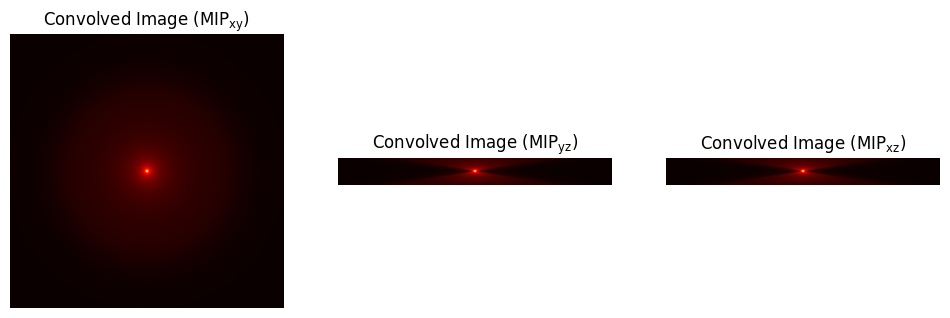

In [33]:
plt.figure(figsize = (12, 8))
# 显示 PSF 的最大值投影
plt.subplot(1,3,1); plt.imshow(np.cbrt(psf_gl).max(0), cmap='hot'); plt.title('Convolved Image (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.cbrt(psf_gl).max(1), cmap='hot'); plt.title('Convolved Image (MIP$_{yz}$)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(np.cbrt(psf_gl).max(2), cmap='hot'); plt.title('Convolved Image (MIP$_{xz}$)'); plt.axis('off')
plt.show()

In [34]:
def calculate_error(psf1, psf2):
    """
    计算两个 psf 之间的误差并返回
    首先需要对两个 psf 各自进行归一化
    """
    psf1 = psf1 / psf1.sum()
    psf2 = psf2 / psf2.sum()
    return np.abs(psf1 - psf2).sum()

error = calculate_error(psf_gl, psf.detach().cpu().numpy())
print(f"PSF 误差: {error.item()}")


PSF 误差: 0.19626764185413847
